# Cellbender testing - Filtering

<div class="alert alert-warning">
    
**What the second section (Filtering) does**

This section visualizes various quality control metric values and filters the data based on a threshold made on the observations/domain knowledge. The section contains the following important subsections:

* Doublet filtering <br>
* UMIs and gene counts filtering <br>
    

</div> 

### Loading libraries
Using sc2_seurat environment

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/bin/python
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:40:17) 
[GCC 9.4.0]
sys.version_info(major=3, minor=9, micro=9, releaselevel='final', serial=0)


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import os
import matplotlib.pyplot as plt

%matplotlib inline
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color

# This is used
# os.path.join('data/'+object_names[i][6:10]+'_preprocessed.h5ad')
#sc.logging.print_versions()

## Load data
The filtered .h5ad  files from preprocessing section.

In [3]:
#siletti
siletti_preprocessed='/home/hers_basak/jjiang/jack/outputs/deliverables/0_cellbender/data/siletti_preprocessed.h5ad'
siletti_CB_preprocessed='/home/hers_basak/jjiang/jack/outputs/deliverables/0_cellbender/data/siletti_CB_preprocessed.h5ad'



#altena
altena_preprocessed='/home/hers_basak/jjiang/jack/outputs/deliverables/0_cellbender/data/altena_preprocessed.h5ad'
altena_CB_preprocessed='/home/hers_basak/jjiang/jack/outputs/deliverables/0_cellbender/data/altena_CB_preprocessed.h5ad'


In [4]:
!ls /home/hers_basak/jjiang/jack/outputs/deliverables/0_cellbender/data/

altena_CB_preprocessed.h5ad  siletti_CB_preprocessed.h5ad
altena_preprocessed.h5ad     siletti_preprocessed.h5ad


In [5]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/0_cellbender')

In [6]:
os.getcwd()

'/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/deliverables/0_cellbender'

In [7]:
!ls

data  figures


In [8]:
files = [siletti_preprocessed,siletti_CB_preprocessed,altena_preprocessed,altena_CB_preprocessed]

In [9]:
names = [name.split('_preprocessed')[0].split('/data/')[1] for name in files ]
print(names)

['siletti', 'siletti_CB', 'altena', 'altena_CB']


In [10]:
object_names_preprocessed =list()
numberobj = len(files)

for i in range(numberobj):
    object_names_preprocessed.append("adata"+"_"+names[i]+"_"+"preprocessed")
    locals()[object_names_preprocessed[i]] = sc.read(files[i]) 
    print(object_names_preprocessed[i],' is loaded')

adata_siletti_preprocessed  is loaded
adata_siletti_CB_preprocessed  is loaded
adata_altena_preprocessed  is loaded
adata_altena_CB_preprocessed  is loaded


## Preprocess - Doublets

<div class="alert alert-warning">

**Important note about doublet filtering**
    
In general the number of doublets looks very low, however, in some runs there seem to be a very close 'bimodal' distribution expression, with the middle point at around 0.2. Following an initial inspection, there doesnt seem to be that many doublets. \
    **TO DO** \
Check if  those with a high score really seem to have high gene counts. Furthermore, mitochondrial and ribosomal genes seem to influence the score for the  'medium' scores (see the plot below). \
I decided to manually set the threshold to 0.20 to filter out some suspicious cells. See if these cluster together  or are dispersed
    

</div>  

### Check gene counts of high doublet scores
Note the graph shows counts excluding mt ones.

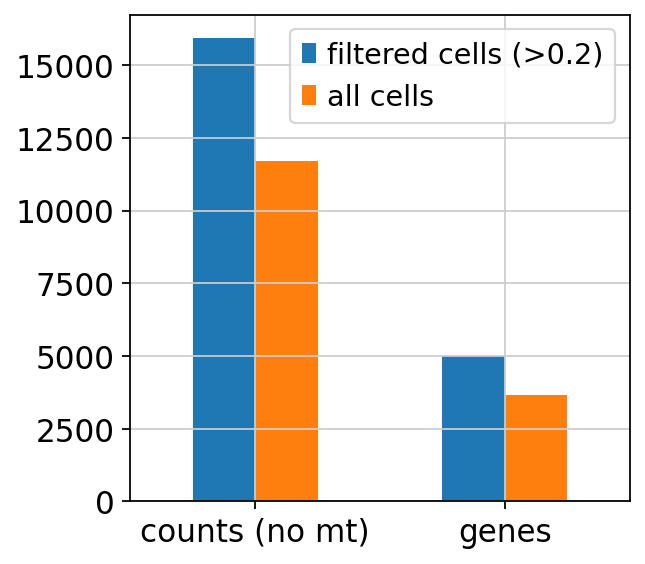

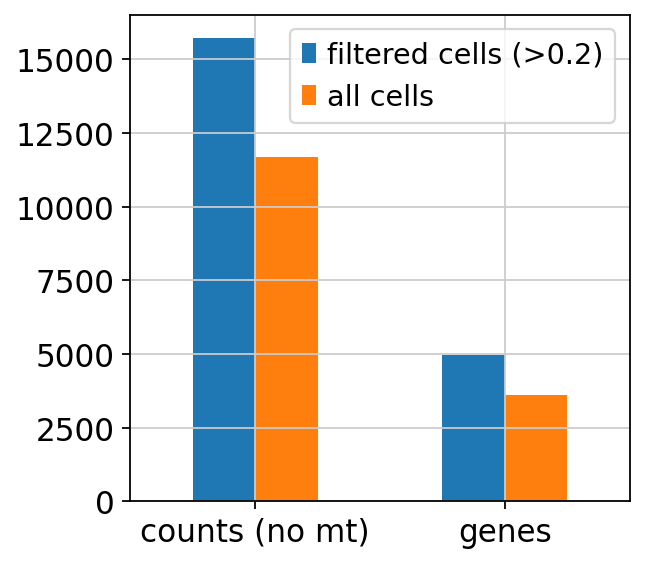

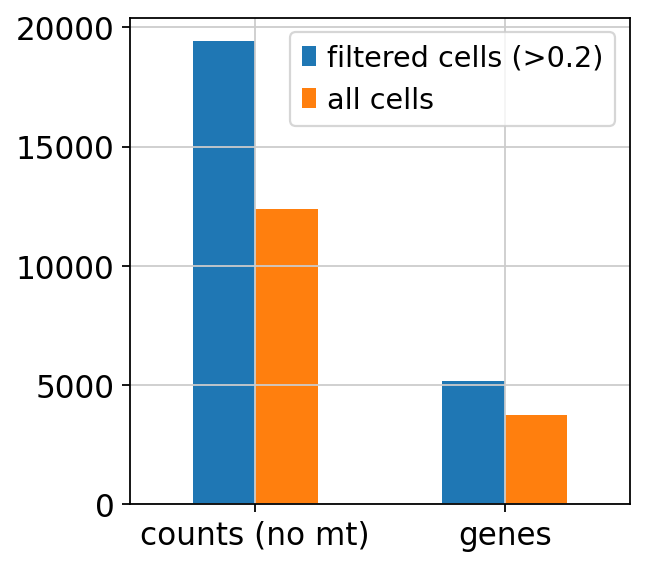

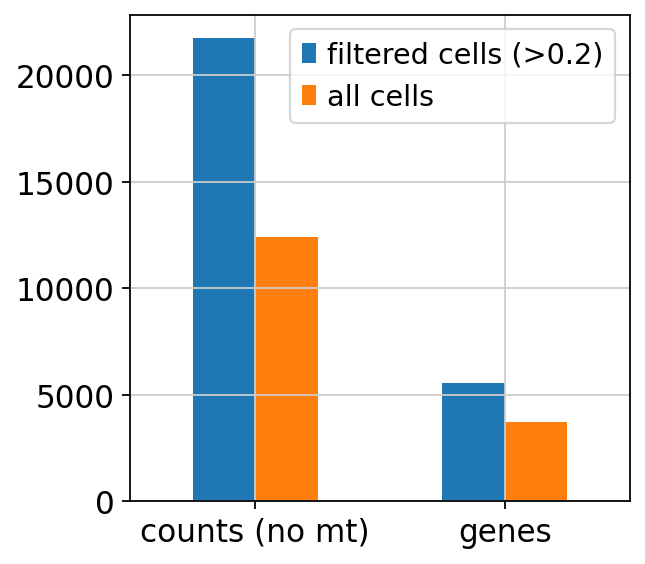

In [12]:
thr_siletti = 0.20
thr_altena = 0.20
for i in range(numberobj):
    
    thr = [thr_siletti, thr_siletti,thr_altena, thr_altena]
    mean_counts_high = int(np.mean(locals()[object_names_preprocessed[i]].obs[locals()[object_names_preprocessed[i]].obs['doublet_score'] > thr[i]]['total_counts']))
    mean_genes_high = int(np.mean(locals()[object_names_preprocessed[i]].obs[locals()[object_names_preprocessed[i]].obs['doublet_score'] >thr[i]]['n_genes']))
    mean_counts = int(np.mean(locals()[object_names_preprocessed[i]].obs['total_counts']))
    mean_genes = int(np.mean(locals()[object_names_preprocessed[i]].obs['n_genes']))
    
    filtered_cells = [mean_counts_high,mean_genes_high]
    all_cells = [mean_counts,mean_genes]
    index = ['counts (no mt)', 'genes']
    
    df = pd.DataFrame({'filtered cells (>0.2)': filtered_cells, 'all cells': all_cells}, index=index)
    ax = df.plot.bar(rot=0)
    
    #print(locals()[object_names[i]].obs[locals()[object_names[i]].obs['doublet_score'] >0.25][['doublet_score','total_counts']])


### Filtering - Doublets

In [13]:
max_doub_score = 0.2 #scrublet usually does middle of two modes, so this is a bit more lenient

for i in range(numberobj):
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]][locals()[object_names_preprocessed[i]].obs['doublet_score'] < max_doub_score]
    print(object_names_preprocessed[i],': filtered!')

adata_siletti_preprocessed : filtered!
adata_siletti_CB_preprocessed : filtered!
adata_altena_preprocessed : filtered!
adata_altena_CB_preprocessed : filtered!


Recalculate values, especially total_counts and without ribo/mito pct change, because there is no mito genes anymore

In [14]:
for i in range(numberobj):
    sc.pp.calculate_qc_metrics(locals()[object_names_preprocessed[i]], expr_type='counts', var_type='genes', qc_vars=(), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
    print(object_names_preprocessed[i],': updated!')

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


adata_siletti_preprocessed : updated!


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


adata_siletti_CB_preprocessed : updated!


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


adata_altena_preprocessed : updated!


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


adata_altena_CB_preprocessed : updated!


## Preprocess - Mitochondrial and Ribosomal counts

In [15]:
for i in range(numberobj):
    print(locals()[object_names_preprocessed[i]])

AnnData object with n_obs × n_vars = 7943 × 60619
    obs: 'species', 'atlas', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
AnnData object with n_obs × n_vars = 7929 × 60619
    obs: 'species', 'atlas', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_c

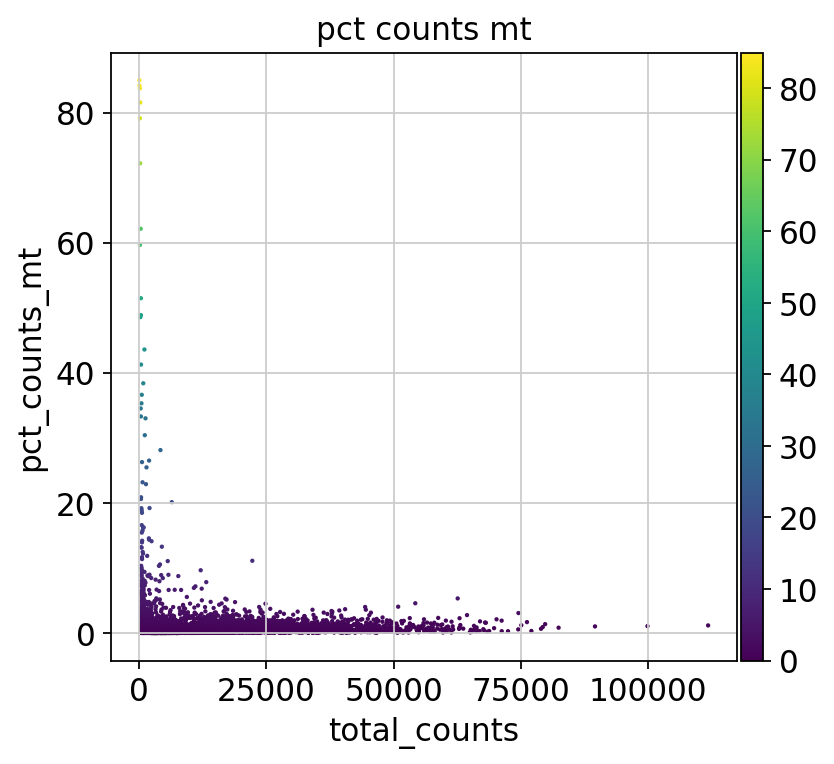

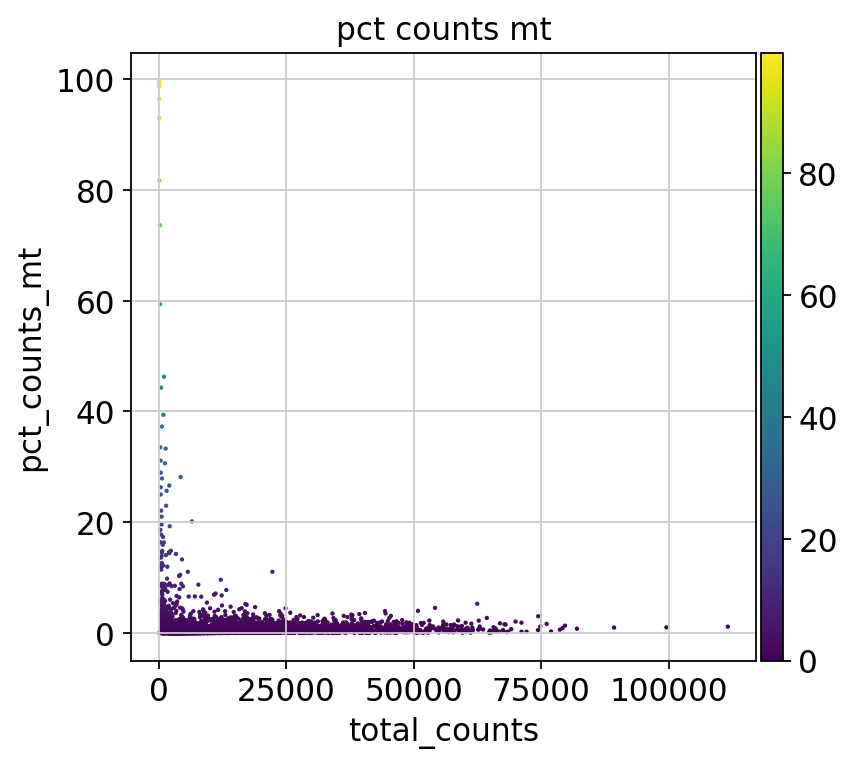

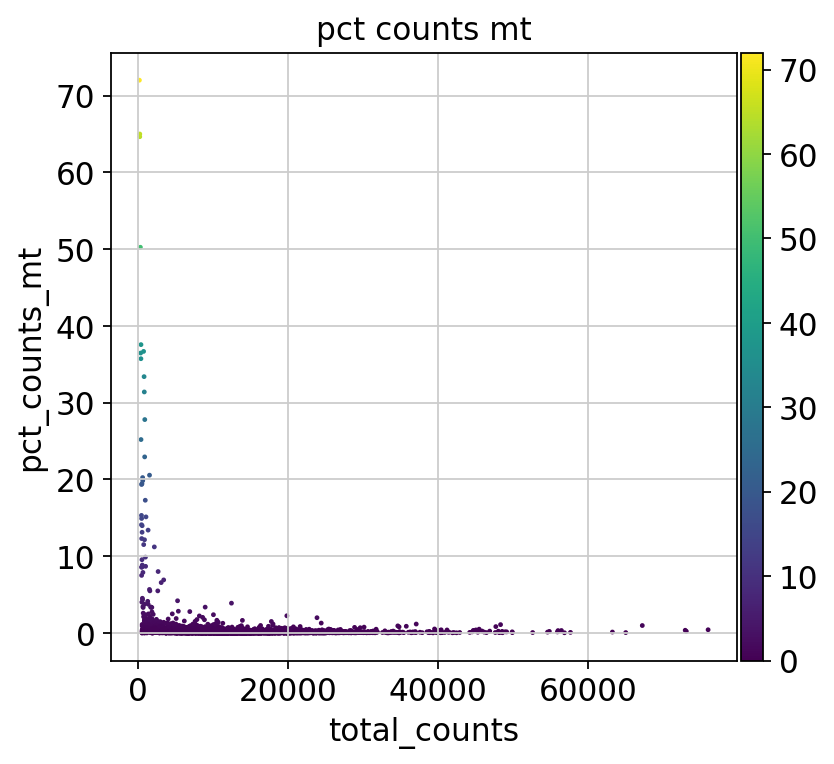

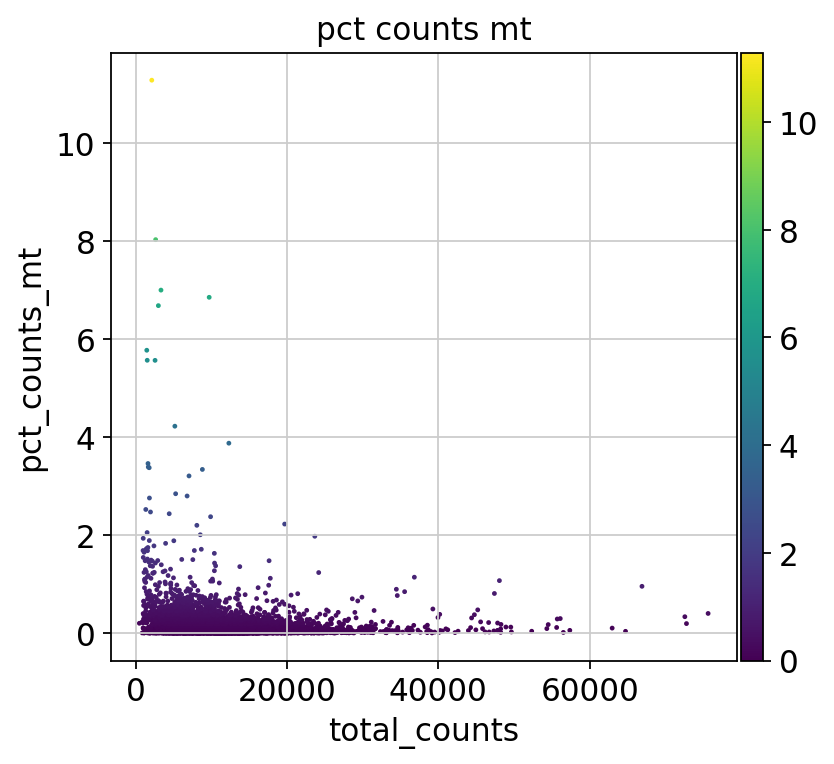

In [16]:
sc.set_figure_params(figsize=[5,5])
for i in range(numberobj):
    sc.pl.scatter(locals()[object_names_preprocessed[i]], x='total_counts', y='pct_counts_mt',color = 'pct_counts_mt',show=False)

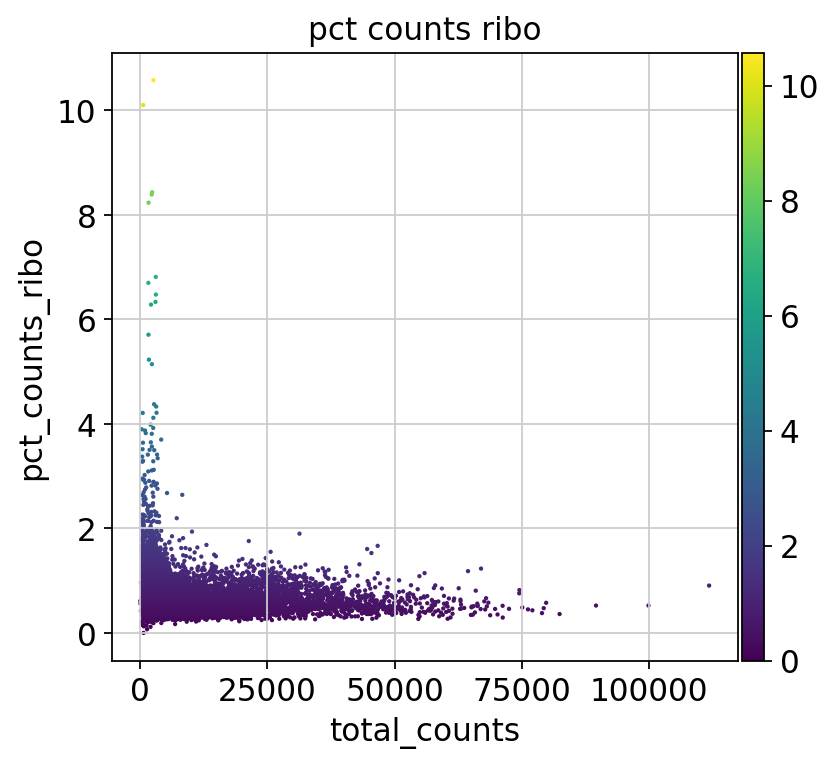

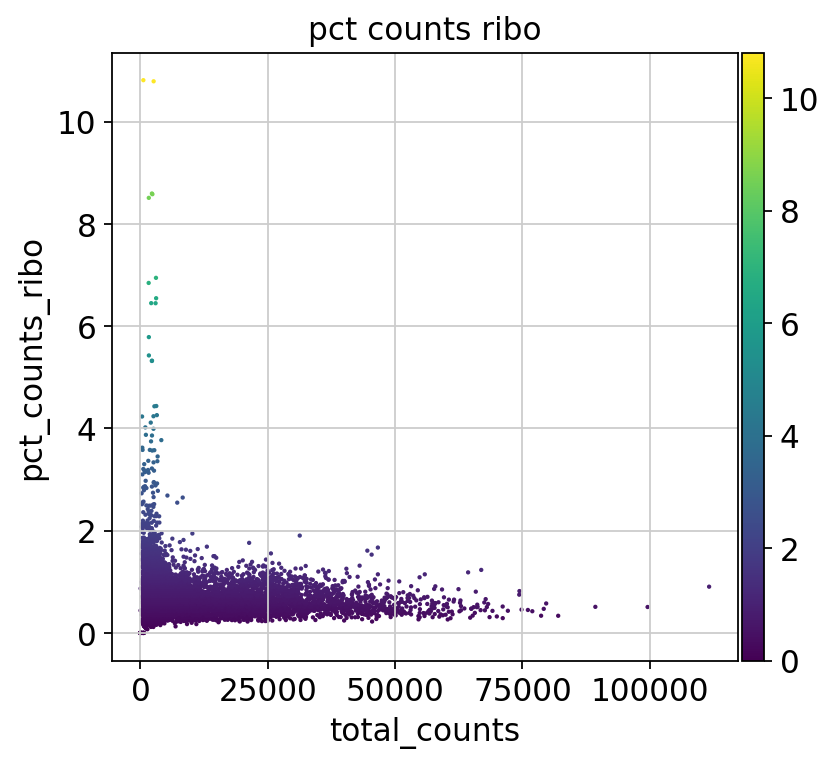

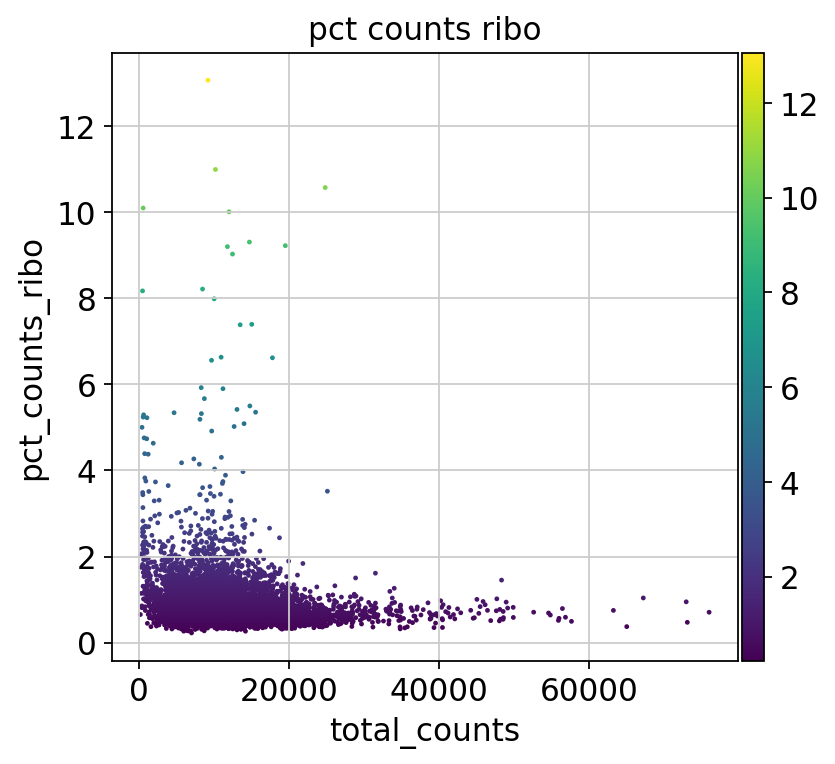

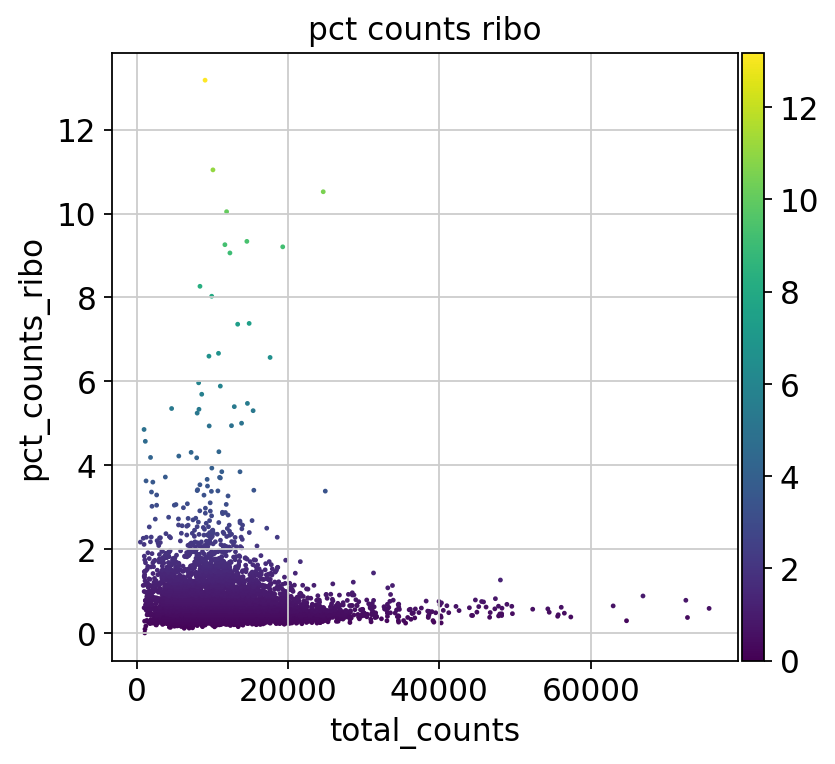

In [17]:
sc.set_figure_params(figsize=[5,5])
for i in range(numberobj):
    sc.pl.scatter(locals()[object_names_preprocessed[i]], x='total_counts', y='pct_counts_ribo',color = 'pct_counts_ribo',show=False)

### Filtering - Mitochondrial% and Ribosomal%

In [18]:
max_pct_mt = 5.0 
max_pct_ribo = 5.0 
for i in range(numberobj):
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]][locals()[object_names_preprocessed[i]].obs['pct_counts_mt'] < max_pct_mt]
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]][locals()[object_names_preprocessed[i]].obs['pct_counts_ribo'] < max_pct_ribo]

## Preprocess - UMIs and gene counts
Here, I want to use some different techniques to plot the data. This is not always necessary, however, you may want to have a close look at your data when you recieve something new. Seaborn package lets us make publication quality and diver plots, while a custom code from the Theis lab, built on Bokeh library, enables interactive plots 

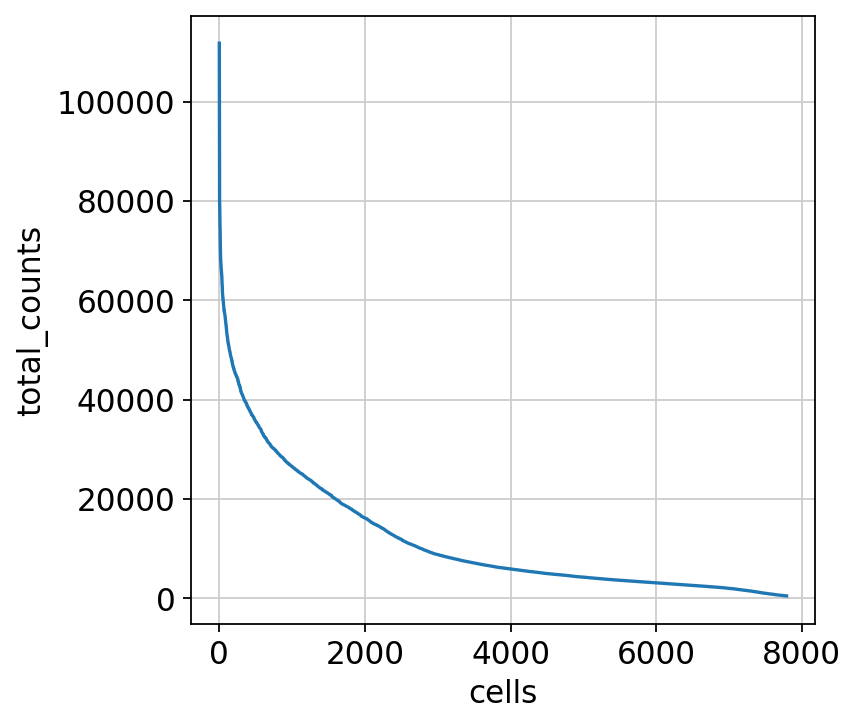

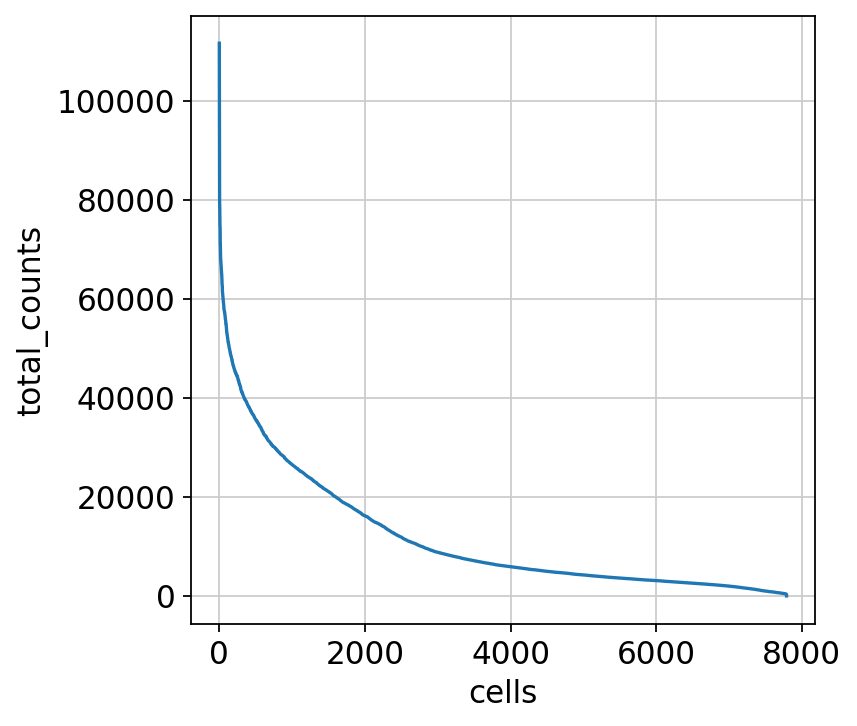

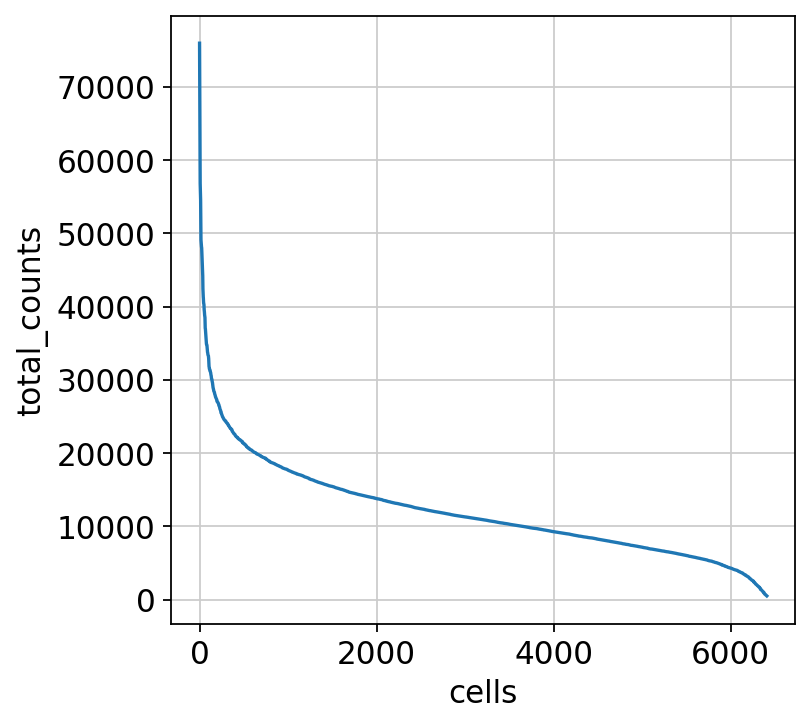

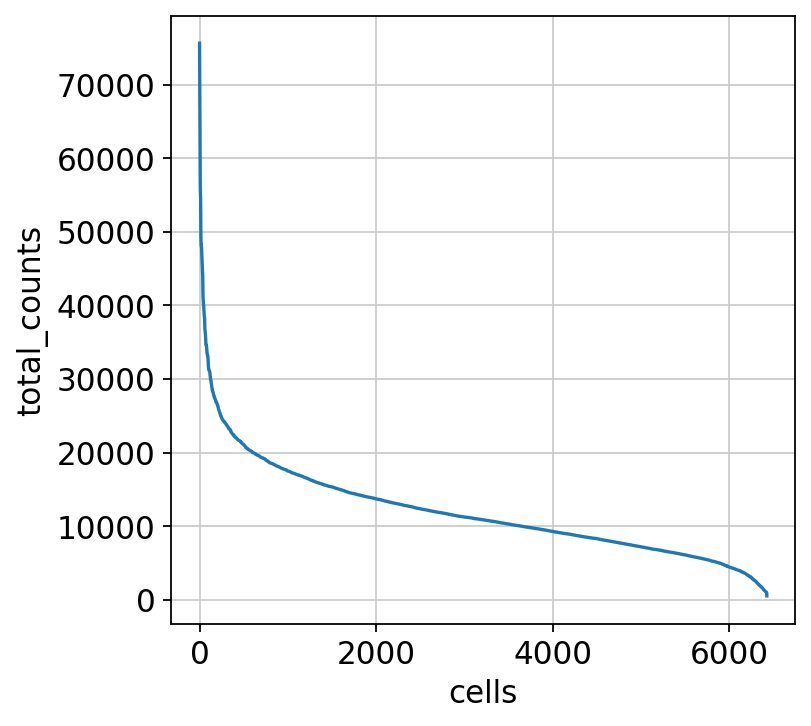

In [19]:
for i in range(numberobj):
    plt.figure()
    total_counts = locals()[object_names_preprocessed[i]].obs['total_counts'].sort_values(ascending = False)
    index = range(len(total_counts))
    plot = sns.lineplot( x = index, y=total_counts )
    plot.set(xlabel='cells')
    plt.show()

### Seaborn hex plots
These plots allow us to see the distribution of the number of genes and reads, as well as where they are most concentrated (dark colors)

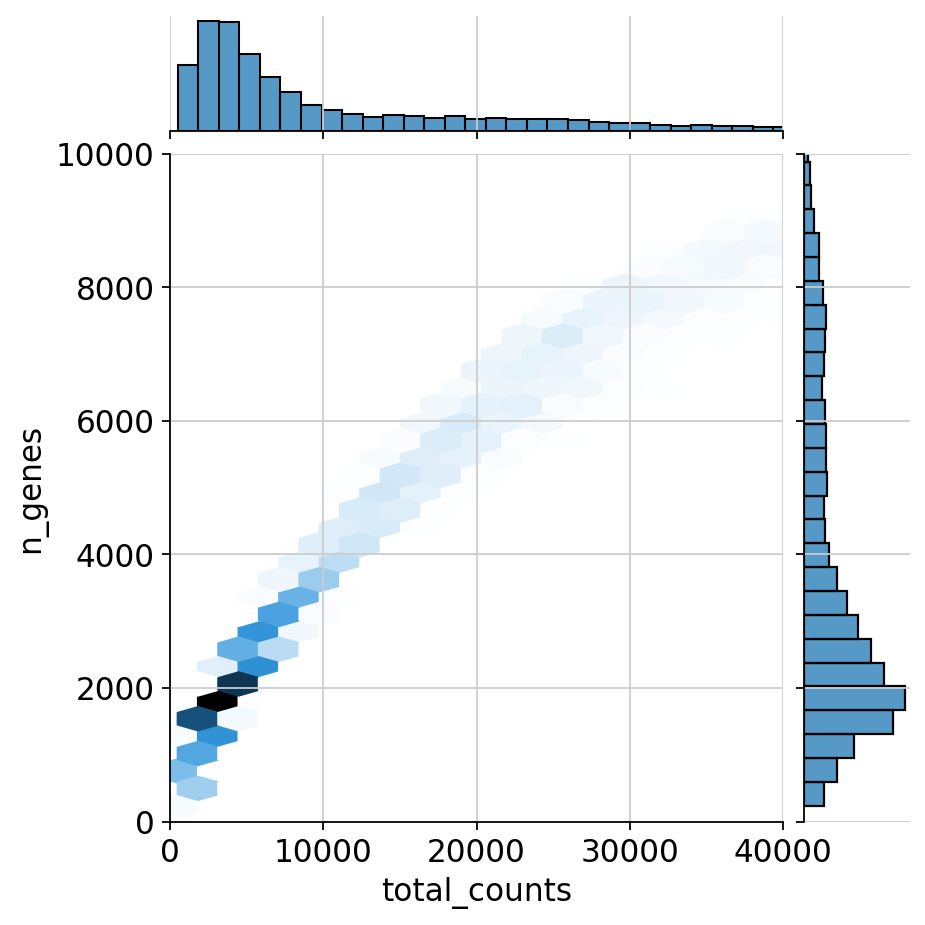

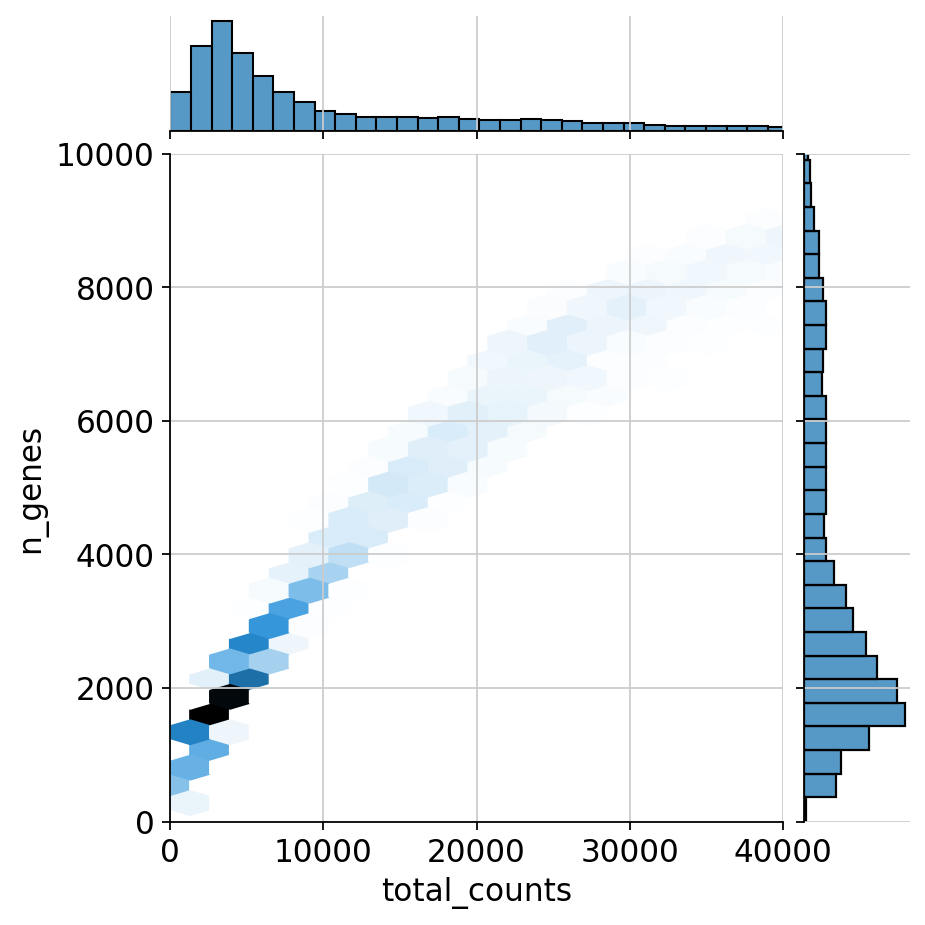

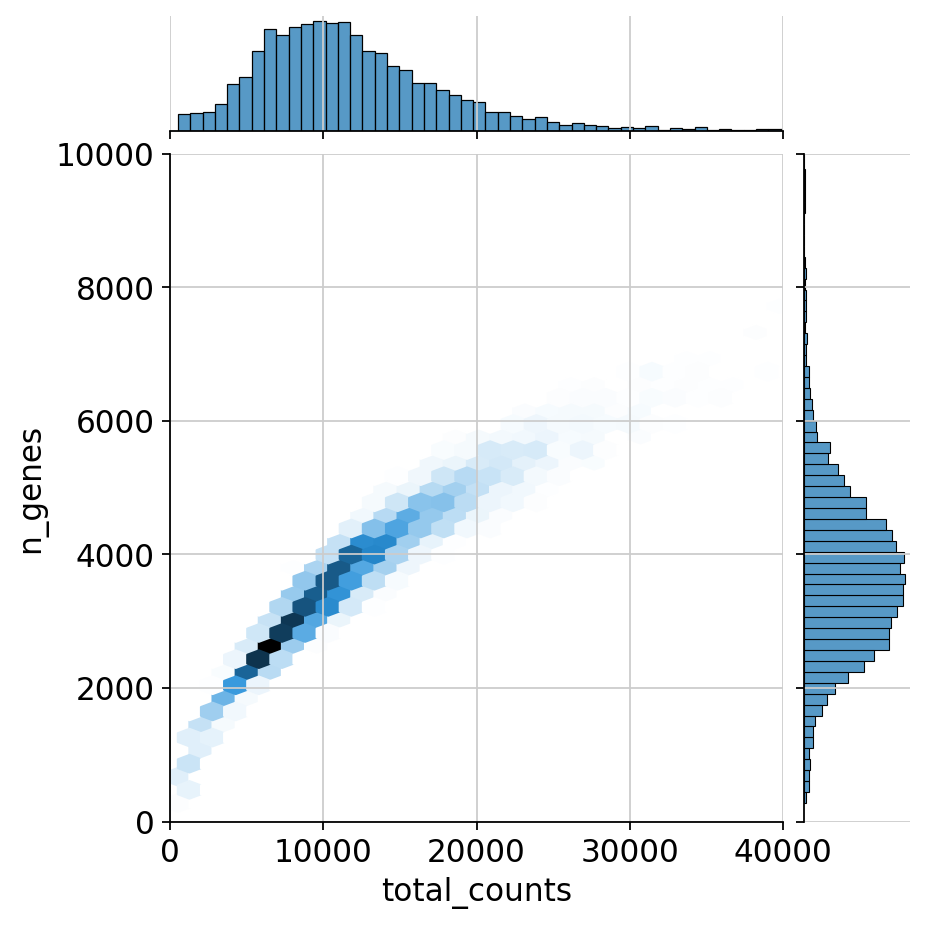

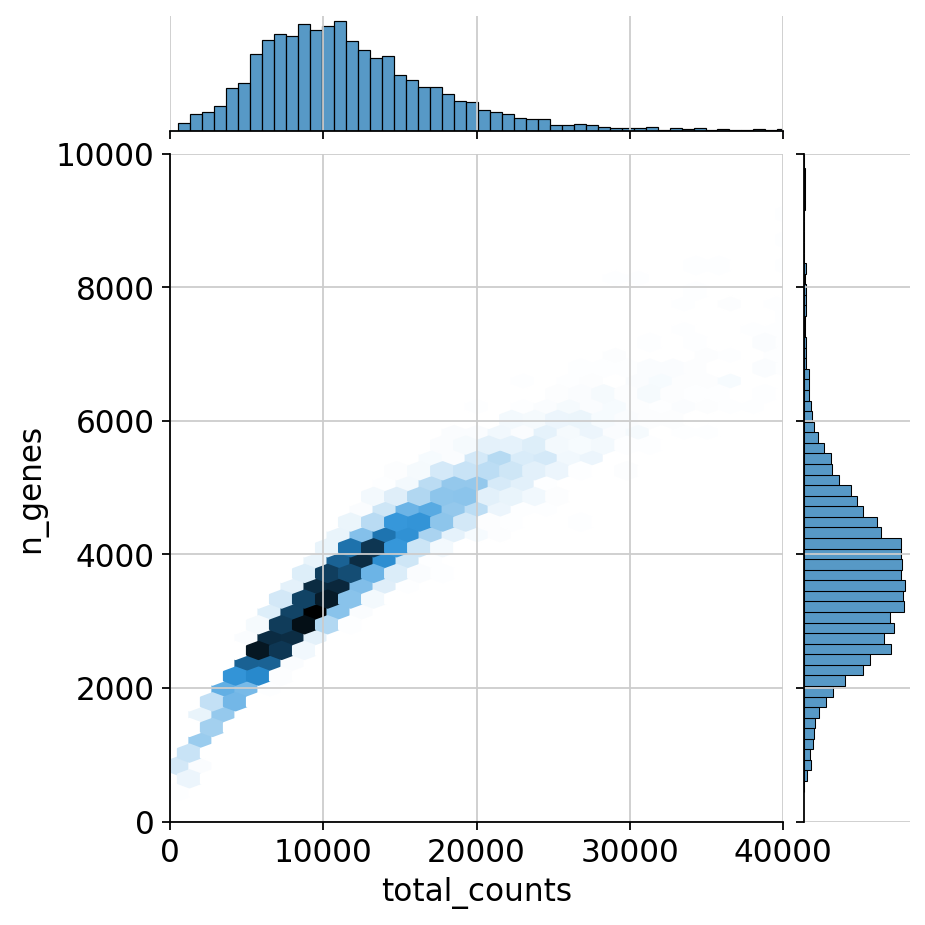

In [22]:
for i in range(numberobj):
    sns.jointplot( x= "total_counts", y= "n_genes", data=locals()[object_names_preprocessed[i]].obs, kind="hex",xlim=[0,40000], ylim=[0,10000])
#kind : { "scatter" | "reg" | "resid" | "kde" | "hex" }

### combined histogram plots
We can compare all libraries to each other using a seaborn histplot

siletti (red = standard, green = cellbender)


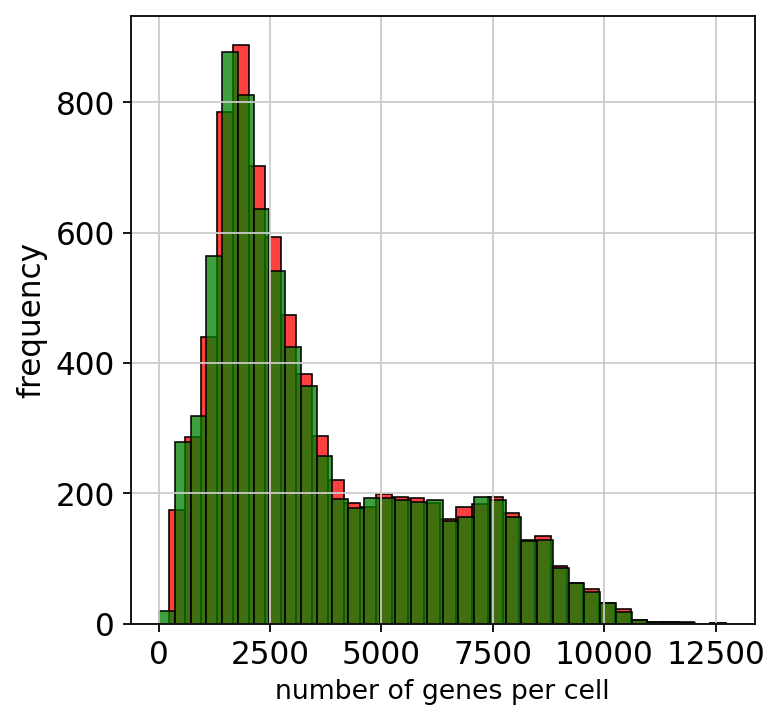

In [24]:
colors_histplot = ['red','green','red','green']
print(f'{names[0]} (red = standard, green = cellbender)')
for i in range(2):
    plot1 = sns.histplot(data=locals()[object_names_preprocessed[i]].obs,x= 'n_genes',color=colors_histplot[i])
    plot1.set_xlabel("number of genes per cell", fontsize = 12)
    plot1.set_ylabel("frequency", fontsize = 14)
    

altena (red = standard, green = cellbender)


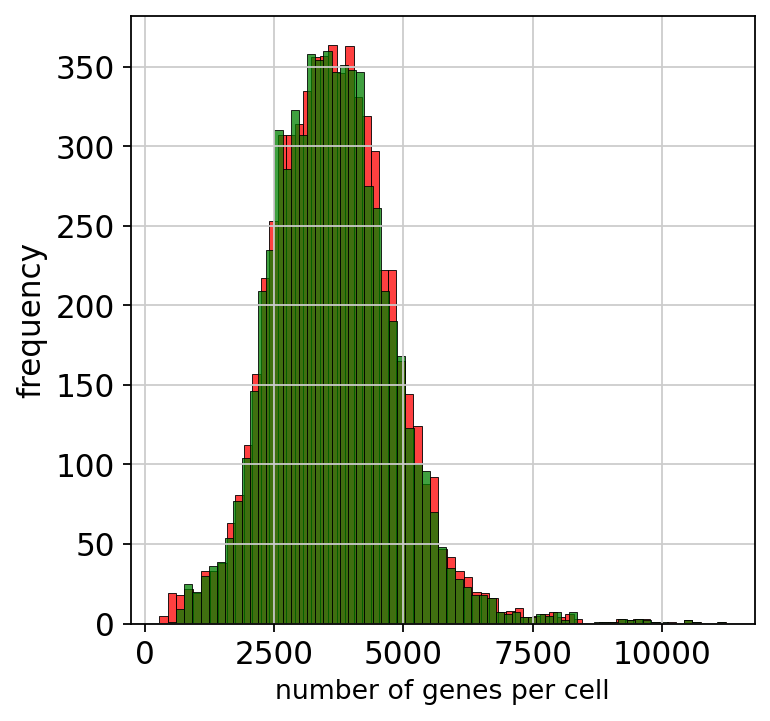

In [25]:

print(f'{names[2]} (red = standard, green = cellbender)')
for i in [2,3]:
    plot2 = sns.histplot(data=locals()[object_names_preprocessed[i]].obs,x= 'n_genes',color=colors_histplot[i])
    plot2.set_xlabel("number of genes per cell", fontsize = 12)
    plot2.set_ylabel("frequency", fontsize = 14)

You might want to focus on one area to choose the 'cutoff'

siletti (red = standard, green = cellbender)


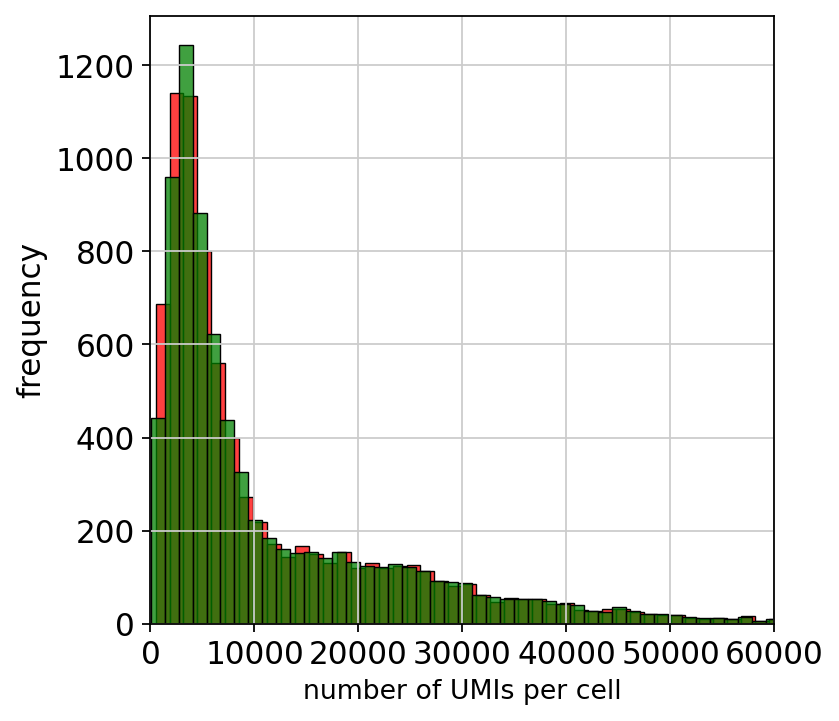

In [26]:
colors_histplot = ['red','green','red','green']

print(f'{names[0]} (red = standard, green = cellbender)')
plt.xlim(0,60000)
for i in range(2):
    plot3 = sns.histplot(data=locals()[object_names_preprocessed[i]].obs,x= 'total_counts',color=colors_histplot[i])
    plot3.set_xlabel("number of UMIs per cell", fontsize = 12)
    plot3.set_ylabel("frequency", fontsize = 14)

altena (red = standard, green = cellbender)


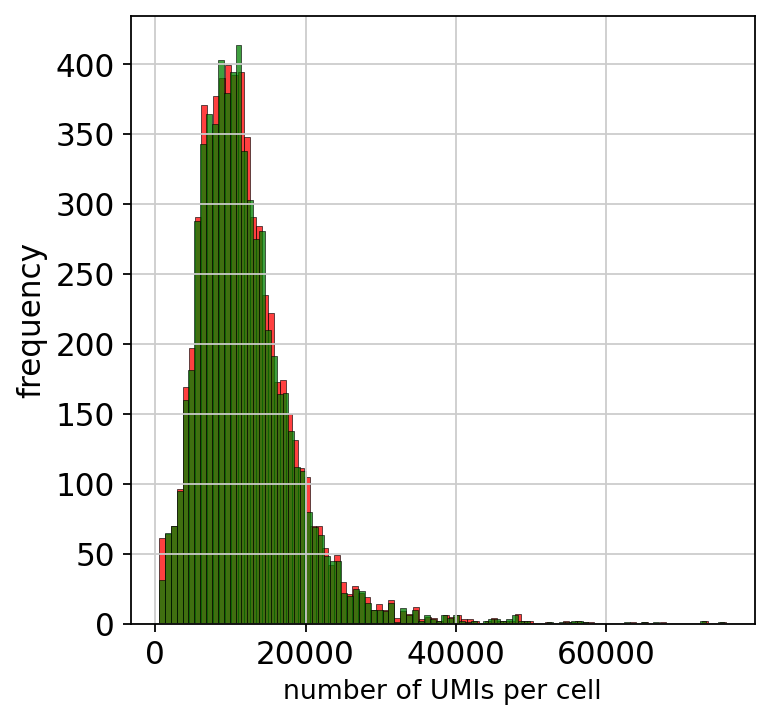

In [27]:

print(f'{names[2]} (red = standard, green = cellbender)')
for i in [2,3]:
    plot4 = sns.histplot(data=locals()[object_names_preprocessed[i]].obs,x= 'total_counts',color=colors_histplot[i])
    plot4.set_xlabel("number of UMIs per cell", fontsize = 12)
    plot4.set_ylabel("frequency", fontsize = 14)

It seems ~10000 is a good cutoff point

### Filtering - UMI and Gene 
Cells with unusual **low/high UMI** counts should be removed. Low counts could be droplets with only ambient RNA while high counts could be doublets. Here we won't filter out cells with high counts as they might represent a celltype. <br>
Similarly cells with unusual **low/high unique gene** counts should be removed. Low gene counts could be droplets with only ambient RNA while high gene counts could be multiplets. <br>
Nonetheless, these thresholds are sample specific and determining them is an iterative process. <br> 

<br>
NOTE: Cell Ranger Count function autmatically filtered out cells with less than 500 UMI counts (might not be the best for heterogenous data). <br>
For more information see: https://www.10xgenomics.com/resources/analysis-guides/common-considerations-for-quality-control-filters-for-single-cell-rna-seq-data 

In [28]:
min_counts = 500 #default
max_counts = 60000
min_genes = 500
max_genes = 10000
min_cells = 3



for i in range(numberobj):
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]][locals()[object_names_preprocessed[i]].obs['total_counts']>=min_counts]
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]][locals()[object_names_preprocessed[i]].obs['total_counts'] < max_counts ]
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]][locals()[object_names_preprocessed[i]].obs['n_genes'] >= min_genes]
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]][locals()[object_names_preprocessed[i]].obs['n_genes'] < max_genes]
    
    sc.pp.filter_genes(locals()[object_names_preprocessed[i]], min_cells=min_cells)

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


### Recalculate metrics

In [29]:
for i in range(numberobj):
    sc.pp.calculate_qc_metrics(locals()[object_names_preprocessed[i]], expr_type='counts', var_type='genes', qc_vars=(), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
    print(locals()[object_names_preprocessed[i]])
    print(locals()[object_names_preprocessed[i]].obs['total_counts'])

AnnData object with n_obs × n_vars = 7618 × 36135
    obs: 'species', 'atlas', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'total_counts_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'
AAACCCAAGTTTCGAC-1     3495.0
AAACCCACATCGTTCC-1     8578.0
AAACCCAGTTATTCTC-1     6431.0
AAACCCATCGAGAGCA-1     8486.0
AAACCCATCGGAGTGA-1    25804.0
                       ...   
TTTGGTTGTGAGTAAT-1      917.0
TTTGGTTTCGCCTATC-1    10577.0
TTTGGTTTCTAAGAAG-1    29726.0
TTTGTTGCACCCAAGC-1    10720.0
TTTGTTGCAGGCATTT-1    19853.0
Name: total_counts, Length: 7618, dtype: float32
AnnData object with n_obs × n_vars = 7611 × 360

In [30]:
object_names_filtered =list()

for i in range(numberobj):
    object_names_filtered.append("adata"+"_"+names[i]+"_"+"filtered")
    locals()[object_names_preprocessed[i]] = locals()[object_names_preprocessed[i]].copy()

In [31]:
for i in range(numberobj):
    locals()[object_names_preprocessed[i]].write(os.path.join('data/'+object_names_filtered[i][6:]+'_1.h5ad'))

In [32]:
!ls data

altena_CB_filtered_1.h5ad    siletti_CB_filtered_1.h5ad
altena_CB_preprocessed.h5ad  siletti_CB_preprocessed.h5ad
altena_filtered_1.h5ad	     siletti_filtered_1.h5ad
altena_preprocessed.h5ad     siletti_preprocessed.h5ad
